# Keyword Spotting: general training notebook

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [1]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=d9b263d0e80df8d9a7e96feed1d3c82cc1abd2c4b5c13b6229fb7de2ccf21a72
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [2]:
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py

--2023-01-15 21:48:19--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5727 (5.6K) [text/plain]
Saving to: ‘models_utils.py’

models_utils.py     100%[===================>]   5.59K  --.-KB/s    in 0s      

2023-01-15 21:48:19 (64.3 MB/s) - ‘models_utils.py’ saved [5727/5727]

--2023-01-15 21:48:19--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2253 

## Import

In [17]:
import os
import pathlib
import requests
import wget
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils 

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [4]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
Version: 2.9.2


To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [5]:
# uncomment to install python_speech_features
! pip install python_speech_features
! pip install visualkeras

from python_speech_features import logfbank, mfcc, delta
import visualkeras

import preprocessing_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=caa2de7262ad1fbf336d402e0bf6a733900e64b2a87d6b5dbdd58d08baef3099
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 54.9 MB/s eta 0:00:00


To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [6]:
# uncomment to install PyWavelets
! pip install PyWavelets

from pywt import dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 - Data loading 
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [7]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

2428923189/2428923189 [==============================] - 21s 0us/step


Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [8]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = commands[mask]
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['down' 'cat' 'bird' 'yes' 'one' 'backward' 'zero' 'up' 'sheila' 'house'
 'left' 'go' 'three' 'on' 'nine' 'forward' 'six' 'tree' 'seven' 'marvin'
 'right' 'off' 'eight' 'follow' 'stop' 'four' 'happy' 'wow' 'visual' 'two'
 'bed' 'learn' 'dog' 'no' 'five']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [9]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset
File downloaded from GitHub


Encode target labels with value between 0 and n_commands-1.

In [10]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [11]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [12]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      5
1      backward  017c4098_nohash_0.wav      5
2      backward  017c4098_nohash_1.wav      5
3      backward  017c4098_nohash_2.wav      5
4      backward  017c4098_nohash_3.wav      5
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav      6
84839      zero  ffd2ba2f_nohash_2.wav      6
84840      zero  ffd2ba2f_nohash_3.wav      6
84841      zero  ffd2ba2f_nohash_4.wav      6
84842      zero  fffcabd1_nohash_0.wav      6

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     20
1     right  439c84f4_nohash_1.wav     20
2     right  409c962a_nohash_1.wav     20
3     right  dbaf8fc6_nohash_2.wav     20
4     right  a6d586b7_nohash_1.wav     20
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     25
9977   four  ad63d93c_n

#### 1.3.1 - Smoke test
We enable the possibility to perform some tests without loading the entire dataset by setting `smoke_test=True`. With this option the train, validation and test set are reduced to a fraction `smoke_test_frac` of elements. This can be useful to test if everything is working as intended before the full training, or if the current hardware is not powerful enough. 

In [13]:
smoke_test = False
smoke_test_frac = 0.2
smoke_test_threshold = 1000 # minimum length of reduced datasets

if smoke_test:
    len_min = smoke_test_frac * min(len(reference_df_train), len(reference_df_val), len(reference_df_test))
    if len_min < smoke_test_threshold:
        raise Exception(f'One of the reduced datasets would have a number of samples < {smoke_test_threshold}! Select a larger value for "smoke_test_frac".')
    else: 
        reference_df_train = reference_df_train.sample(frac=smoke_test_frac, replace=False)
        reference_df_val   = reference_df_val.sample(frac=smoke_test_frac, replace=False)
        reference_df_test  = reference_df_test.sample(frac=smoke_test_frac, replace=False)

In [14]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


#### 1.3.2 - Dataset distribution
Let's now plot the percentage of elements of each class in each set. 

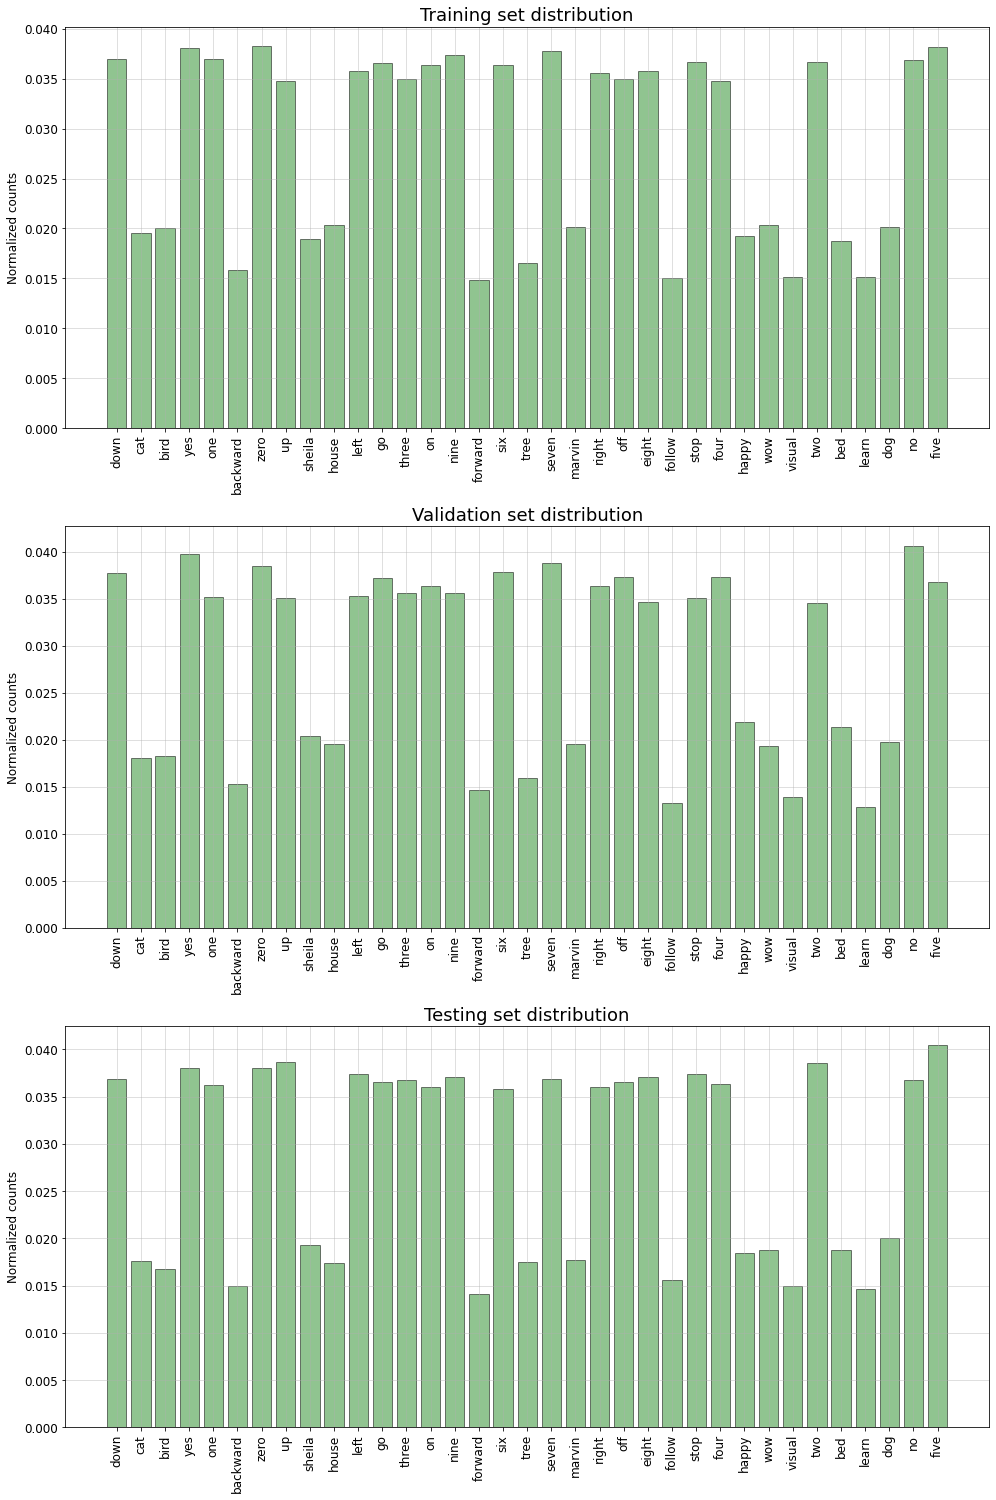

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

plot_utils.hist_class_distribution(reference_df_train, ax[0], commands)
plot_utils.hist_class_distribution(reference_df_val, ax[1], commands)
plot_utils.hist_class_distribution(reference_df_test, ax[2], commands)

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.4 Noise loading 
We load here the available noisy audio signals and we defined the object `noise_dict`, which is required by the function `load_and_preprocessing_data` (see next section).

In [23]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. 

## 2.1 Loading and preprocessing
First, to load and preprocess the data, we use the function `load_and_preprocess_data`, defined in the file `preprocessing_utils.py`. This function puts together all loading and preprocessing methods that can be explored in the notebook `B1_data_analysis_and_preprocessing_inspection.ipynb`. 



In [18]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path, apply_background_noise=False, noise_dict=None, features=1):
    '''
    features:
    - 1 for MFCC features (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    '''
    
    # load data
    data = load_data(file_name, file_label, data_path_=data_path)
    
    # padding/trimming
    data = padding_trimming(data)
    
    # add background noise
    if apply_background_noise:
        data = background_noise(data, noise_dict=noise_dict)

    # extract features
    if features == 1:
        data_features = get_mfcc(data)
    
    elif features == 2:
        data_features = get_logfbank(data)

    elif features == 3:
        data_features = get_spectrogram(data)

    elif features == 4:
        data, _ = dwt(data=data, wavelet='db1', mode='sym')
        data_features = get_mfcc(data)
      
    else:
        raise Exception("'featur

### 2.1 - Dataset definition
We now define the `create_dataset` function, which initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [30]:
def load_and_preprocess_noisedict_passed(file_name, file_label, data_path_=data_path, apply_background_noise=False, features=1):
  return preprocessing_utils.load_and_preprocess_data(file_name, file_label, data_path_=data_path, apply_background_noise=False, noise_dict=noise_dict, features=1)


In [31]:
def create_dataset(df, data_path_=data_path, apply_background_noise=False, features=1, cache_file=None, shuffle=True, batch_size=32):

    # Convert DataFrame to lists
    file_names = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the load_and_preprocess_data function
    def numpy_func(file_name, file_label):
        return tf.numpy_function(load_and_preprocess_noisedict_passed, inp=[file_name, file_label, data_path_, apply_background_noise, features], Tout=tf.float32), file_label
    dataset = dataset.map(numpy_func, num_parallel_calls=os.cpu_count())

    # Cache
    if cache_file:
        dataset = dataset.cache(filename=cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    # Steps
    steps = int(np.ceil(len(df) / batch_size))

    return dataset, steps

### 2.2 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).


In [32]:
'''
    features_to_extract:
    - 1 for MFCC features (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
'''

apply_bn = True
features_to_extract = 1
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train, 
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='train_cache',
    shuffle=True,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='val_cache',
    shuffle=True,
    batch_size=batch_size
)

# important, shuffle=False and do not apply bn in the test set
apply_bn=False
test_dataset, test_steps = create_dataset(
    reference_df_test,
    apply_background_noise=apply_bn, 
    features=features_to_extract,
    cache_file='test_cache',
    shuffle=False,
    batch_size=batch_size
)

## 3 - Models

### 3.1 - Import model
Here we select one of the available network architectures in the file `models_utils.py`.

In [33]:
############### Sainath15 notation ###############
t = 99 # input feature dimension in time
f = 39 # input feature dimension in frequency

# 1st CONV layer
m = 20 # filter size in time
r = 8  # filter size in frequency
s = 1  # stride in time
v = 1  # stride in frequency
p = 1  # max-pooling in time
q = 3  # max-pooling in frequency
##################################################

In [34]:
available_models()

Available models:
cnn_trad_fpool3
cnn_one_fpool3
cnn_one_fstride4
cnn_one_fstride8
smallCnnModel
cnnModel


In [35]:
features_to_input = { # input shapes
    1 : (99, 39),     # MFCC features
    2 : (99, 40),     # log Mel-filterbank energy features
    3 : (98, 257),    # spectrogram
    4 : (49, 39)      # Discrete Wavelet Transform + MFCC features
}

input_shape = features_to_input[features_to_extract]
model_name = 'smallCnnModel'
model = select_model(model_name, input_shape)

Selected model: smallCnnModel


In [36]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "smallCnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 99, 39, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 99, 39, 32)        352       
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 39, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 9, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 9, 64)        256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 99, 9, 64)       

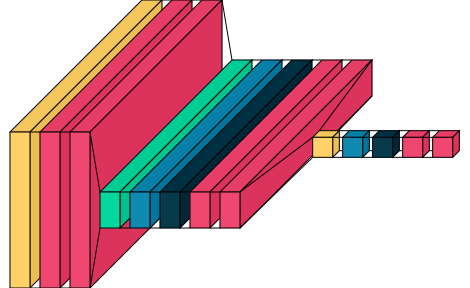

In [37]:
visualkeras.layered_view(model)

In [38]:
# Show the structure of the model through building blocks
# tf.keras.utils.plot_model(model, to_file=f'{model_name}.png')
# Image(f'{model_name}.png')

## 4 - Model training and testing

### 4.1 - Model training
At this point we can train the model for some epochs.

In [39]:
num_epochs = 2

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                verbose=1
                )

Epoch 1/2
2652/2652 [==============================] - 514s 51ms/step - loss: 1.6797 - sparse_categorical_accuracy: 0.5241 - val_loss: 0.8587 - val_sparse_categorical_accuracy: 0.7464 - lr: 0.0010
Epoch 2/2
2652/2652 [==============================] - 56s 21ms/step - loss: 1.0088 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.8005 - lr: 0.0010


In [40]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,1.679722,0.524074,0.85872,0.746394,0.001
1,1.008759,0.701746,0.66792,0.800481,0.001


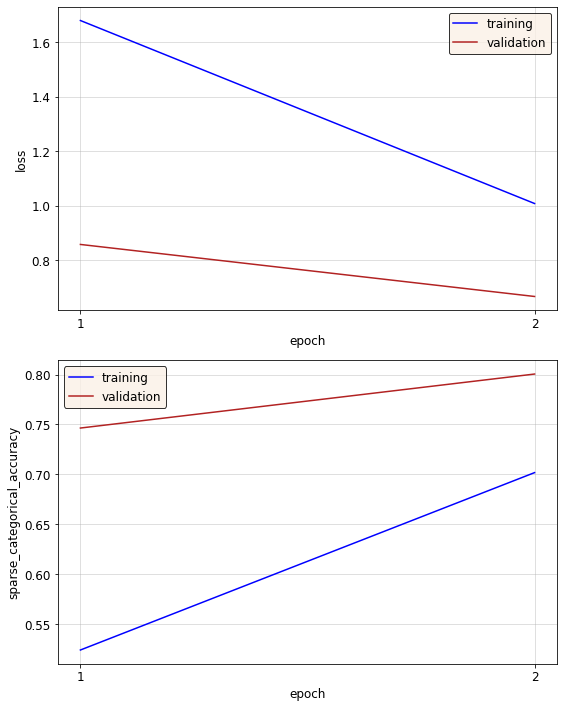

In [41]:
plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the weights of the trained model.

In [42]:
# model.save_weights(f'trained_models/{model_name}.h5')

Uncomment the cell below to load some pretrained models.

In [43]:
# model_name = 'smallCnnModel'
# model = tf.keras.models.load_model(f'{model_name}.h5')
# model.summary()

### 4.2 - Validation metrics
Since the dataset is unbalanced (see histograms in section 1.4) and we have more than 2 classes, the accuracy is not a good metric. To have a good understanding of the classifier performance we must rely on other metrics.  

First we compute the output of the network for all data in the test set. To obtain it use:
```python 
    model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()
```
This is needed because the elements in `[len(val_labels):]` are not part of the dataset, but they are just added to complete the batch. 

Then we get the predicted label by computing the $argmax$ over the output of the network, for each input data. This is motivated by the fact that there are as many neurons as labels in the last layer of the network and we used the softmax activation function. 

In [44]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

344/344 [==============================] - 56s 161ms/step


Then, to visualize the performance of the algorithm we plot the confusion matrix:

In [ ]:
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')
# plt.savefig(f'figures/cm_{model_name}.png')

Moreover, we can evaluate the _precision_, _recall_ and _fscore_ metrics using some methods from the *scikit-learn* library. These metrics are calculated for each class in the dataset, so to get an a high-level view of how our model is performing we need to aggregate them. This can be done in 3 main ways:

1. **Macro average**: it is the unweighted average of the selected metric; it does not take label unbalance into account.
2. **Micro average**: it is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average; in other words it calculates the metrics globally by counting the total TP, FP and FN.
3. **Weighted average**: it is the average of the metric values for individual classes weighted by the support (i.e. the number of true instances) of that class. It alters _macro_ to account for label imbalance.

In our case, dealing with unbalanced classes, we are more interesting in the weighted average of the considered metrics.

Another interesting measure for multiclass classification is the _Cohen's Kappa score_. From [Wikipedia](https://en.wikipedia.org/wiki/Cohen%27s_kappa):
> Cohen’s kappa coefficient (κ) is a statistic that is used to measure inter-rater reliability (and also intra-rater reliability) for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.

It can be thought as a version of the accuracy which also integrates measurements of chance and class imbalance. Generally, a score above 0.8 is considered excellent. See [this guide](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c) for more information about it. 



In [ ]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

print('Accuracy:      {:.2f}%'.format(accuracy*100))
print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
print('Cross-entropy: {:.4f}'.format(logloss))
print("Cohen's Kappa: {:.4f}".format(cohen_k))

def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

cr = class_report(y_true, y_pred)
display(cr.round(4))

In [ ]:
weighted_metrics = cr.iloc[-1].tolist()

df_metrics = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics.round(4))

# Uncomment next line to store the final metrics 
df_metrics.to_csv(f'metrics/metr_{model_name}_2.csv')

In [ ]:
# tmp1 = pd.read_csv('metr_smallCnnModel_1.csv', index_col=0)
# tmp2 = pd.read_csv('metr_smallCnnModel_2.csv', index_col=0)
# 
# df_ = pd.concat([tmp1, tmp2], ignore_index=True, axis=0)
# df_['Training'] = ['Without Delta', 'With Delta']
# df_ = df_.set_index(['Training'])
# df_

# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.
